In [1]:
!git clone -b shapemask https://github.com/tensorflow/tpu/

Cloning into 'tpu'...
remote: Enumerating objects: 11522, done.
remote: Counting objects: 100% (1724/1724), done.
remote: Compressing objects: 100% (870/870), done.
remote: Total 11522 (delta 985), reused 1455 (delta 812), pack-reused 9798
Receiving objects: 100% (11522/11522), 47.07 MiB | 8.68 MiB/s, done.
Resolving deltas: 100% (8023/8023), done.


In [2]:
from IPython import display
from PIL import Image #Pythin Image library
import numpy as np
import sys
import os
import pprint #Pretty Print
import tensorflow.compat.v1 as tf #tensorflow V1 compatiblity

In [3]:
sys.path.insert(0, '/content/tpu/models/official')
sys.path.insert(0,'/content/tpu/models/official/detection')
sys.path.insert(0,'/content/tpu/models/official/detection/utils')
from utils.object_detection import visualization_utils
from evaluation import coco_utils

In [8]:
ID_MAPPING = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    4: 'motorcycle',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    11: 'fire hydrant',
    13: 'stop sign',
    14: 'parking meter',
    15: 'bench',
    16: 'bird',
    17: 'cat',
    18: 'dog',
    19: 'horse',
    20: 'sheep',
    21: 'cow',
    22: 'elephant',
    23: 'bear',
    24: 'zebra',
    25: 'giraffe',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    32: 'tie',
    33: 'suitcase',
    34: 'frisbee',
    35: 'skis',
    36: 'snowboard',
    37: 'sports ball',
    38: 'kite',
    39: 'baseball bat',
    40: 'baseball glove',
    41: 'skateboard',
    42: 'surfboard',
    43: 'tennis racket',
    44: 'bottle',
    46: 'wine glass',
    47: 'cup',
    48: 'fork',
    49: 'knife',
    50: 'spoon',
    51: 'bowl',
    52: 'banana',
    53: 'apple',
    54: 'sandwich',
    55: 'orange',
    56: 'broccoli',
    57: 'carrot',
    58: 'hot dog',
    59: 'pizza',
    60: 'donut',
    61: 'cake',
    62: 'chair',
    63: 'couch',
    64: 'potted plant',
    65: 'bed',
    67: 'dining table',
    70: 'toilet',
    72: 'tv',
    73: 'laptop',
    74: 'mouse',
    75: 'remote',
    76: 'keyboard',
    77: 'cell phone',
    78: 'microwave',
    79: 'oven',
    80: 'toaster',
    81: 'sink',
    82: 'refrigerator',
    84: 'book',
    85: 'clock',
    86: 'vase',
    87: 'scissors',
    88: 'teddy bear',
    89: 'hair drier',
    90: 'toothbrush',
}
category_index = {k: {'id': k, 'name': ID_MAPPING[k]} for k in ID_MAPPING}

In [ ]:
image_path = 'testimage.jpg' #Street With Peoples And Bicycle
with open(image_path, 'rb') as f: #Open file in Binary read Mode
  np_image_string = np.array([f.read()])

image = Image.open(image_path) #Open Image With PIL
width , height = image.size
np_image = np.array(image.getdata()).reshape(height, width,3).astype(np.uint8) #numpy arry is Creeated
#Reshaped And Dimensions Are Matched And Casted to np.uint8 tpe
display.display(display.Image(image_path, width=1024)) #Loads A image From IPython Library display module

In [ ]:
#create A tensorflow Session
use_tpu = True
if use_tpu:
  assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not Connected to TPU , Change The Runtime To TPU'
  TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print('TPU Address is ', TPU_ADDRESS)
  session = tf.Session(TPU_ADDRESS, graph=tf.Graph())
  pprint.pprint(session.list_devices())
else:
  session = tf.Session(graph = tf.Graph())

In [24]:
saved_model_dir = 'gs://cloud-tpu-checkpoints/shapemask/1571767330' #@param {type:"string"}

_ = tf.saved_model.loader.load(session, ['serve'], saved_model_dir)

In [39]:
num_detections, detection_boxes, detection_classes, detection_scores, detection_masks, detection_outer_boxes, image_info = session.run(
    ["NumDetections:0","DetectionBoxes:0","DetectionClasses:0","DetectionScores:0","DetectionMasks:0","DetectionOuterBoxes:0","ImageInfo:0"], feed_dict={'Placeholder:0':np_image_string})

[]
num_detections = np.squeeze(num_detections.astype(np.int32), axis=(0,))
detection_boxes = np.squeeze(detection_boxes / min(image_info[0,2]),axis=(0,))[0:num_detections]
detection_outer_boxes = np.squeeze(detection_outer_boxes /min(image_info[0,2]), axis=(0,))[0:num_detections]
detection_scores = np.squeeze(detection_scores,axis=(0,))[0:num_detections]
detection_classes = np.squeeze(detection_classes.astype(np.int32), axis=(0,))[0:num_detections]
instance_masks = np.squeeze(detection_masks, axis=(0,))[0:num_detections]


ymin , xmin, ymax , xmax = np.split(detection_outer_boxes,4,axis=-1)
processed_boxes = np.concatenate([xmin, ymin, xmax-xmin, ymax-ymin], axis=-1)

segmentations = coco_utils.generate_segmentation_from_masks(instance_masks,processed_boxes, height,width)

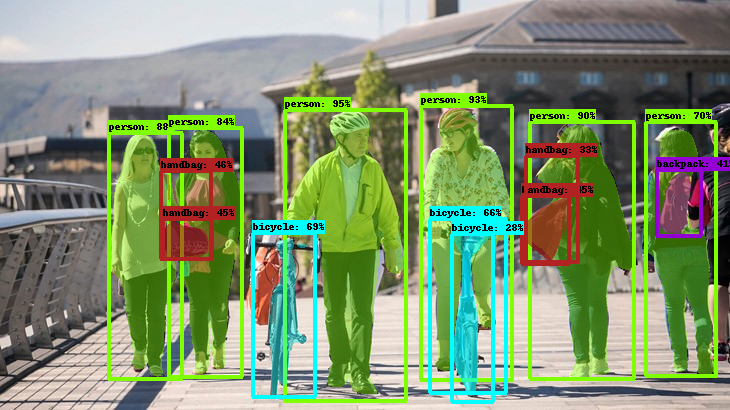

In [42]:
#max_boxes_to_draw = 25 #@param {type:"integer"}
#min_score_thresh = 0.27 #@param {type:"slider", min:0, max:1, step:0.01}

max_boxes_to_draw = 25
min_score_thresh = 0.27

image_with_detections = visualization_utils.visualize_boxes_and_labels_on_image_array(
    np_image *1,
    detection_boxes,
    detection_classes,
    detection_scores,
    category_index,
    instance_masks = segmentations,
    use_normalized_coordinates = False,
    max_boxes_to_draw = max_boxes_to_draw,
    min_score_thresh = min_score_thresh
)

output_image_path = 'test_results.png'
Image.fromarray(image_with_detections.astype(np.uint8)).save(output_image_path)
display.display(display.Image(output_image_path, width=1024))